# Unit Testing Optimisation

## Importing the Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial
from itertools import chain

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, pmap, random, lax, value_and_grad, tree_multimap, tree_map, devices

import time

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

In [3]:
num_mach = 10

## Defining SE Covariance

In [4]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [5]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Obtaining Training Data

### Importing Spike Trains and Finger Movement

In [6]:
alldata = pd.read_hdf('./Data/Allfinger_veldata.h5') # Import DataFrame

In [7]:
trainind = (0, 1, 2)

In [8]:
alldata.loc[0].to_numpy().shape

(159913, 132)

In [9]:
data = [alldata.loc[i] for i in trainind]

In [10]:
data[2]

signal_type            finger_vel           spikes                           \
channel                         x         y    201  203  204  301  401  601   
0 days 00:00:00         -0.391595  0.598059    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  -0.389108  0.584754    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  -0.387002  0.571926    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  -0.385276  0.559577    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  -0.383921  0.547705    0.0  0.0  0.0  0.0  0.0  0.0   
...                           ...       ...    ...  ...  ...  ...  ...  ...   
0 days 00:02:41.916000  -0.409614 -1.557836    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.917000  -0.417498 -1.572530    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.918000  -0.425806 -1.586831    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.919000  -0.434551 -1.600731    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.920000  -0.443748 -1.614225    0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                       ...                                          \
channel                 701  802  ... 9001 9103 9201 9203 9301 9403 9501 9502   
0 days 00:00:00         0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
0 days 00:02:41.916000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.917000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.918000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.919000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.920000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                       
channel                9601 9602  
0 days 00:00:00         0.0  0.0  
0 days 00:00:00.001000  0.0  0.0  
0 days 00:00:00.002000  0.0  0.0  
0 days 00:00:00.003000  0.0  0.0  
0 days 00:00:00.004000  0.0  0.0  
...                     ...  ...  
0 days 00:02:41.916000  0.0  0.0  
0 days 00:02:41.917000  0.0  0.0  
0 days 00:02:41.918000  0.0  0.0  
0 days 00:02:41.919000  0.0  0.0  
0 days 00:02:41.920000  0.0  0.0  

[161921 rows x 132 columns]

In [11]:
# Set number of time bins (k) and number of filters to use
num_tbin = 10000
num_filt = 130
batch_size = num_filt // num_mach
num_filt = num_mach * batch_size
print(num_filt)

130


In [12]:
# All to correspond to dims (nummach, numsam, numfilt, k + 1, 1)

In [13]:
spikedat = [data[i].spikes.to_numpy()[:num_tbin, :num_filt].T[:, :, None] for i in trainind]
n = [np.shape(spikedat[i])[1] - 1 for i in trainind]

In [14]:
print(spikedat[2].shape)

(130, 10000, 1)


In [15]:
ytime = [(data[i].index / np.timedelta64(1, 's')).to_numpy()[:num_tbin] for i in trainind] # Get spikes/output time array

In [16]:
# Get x and y velocities
yraw = [data[i].finger_vel.y.to_numpy()[:num_tbin].reshape(n[i] + 1, 1) for i in trainind]
xraw = [data[i].finger_vel.x.to_numpy()[:num_tbin].reshape(n[i] + 1, 1) for i in trainind]

In [17]:
yraw[0].shape

(10000, 1)

#### Standardising Data

In [18]:
# Set variance to 1.0
yvel = [yraw[i] / np.std(yraw[i]) for i in trainind]
xvel = [xraw[i] / np.std(xraw[i]) for i in trainind]

In [19]:
del data # Clear data from memory

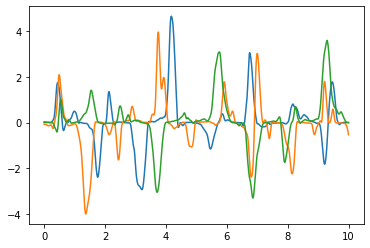

In [20]:
for i in trainind:
  plt.plot(ytime[i], yvel[i])

### Setting up Filter Sizes

In [21]:
# Time bin size
time_bin = ytime[0][1] - ytime[0][0]
print(time_bin)

f_maxt = 1.0 # Filter horizon

k = np.floor(f_maxt/time_bin).astype(np.int16) # Maximum index of filter data

ftime = np.linspace(0.0, f_maxt, k + 1).reshape((k + 1, 1)) # Filter corresponding time array

0.001


### Getting FFT of Spike Data

In [22]:
# FFT of spike train
spikepad = [np.hstack((spikedat[i], np.zeros((num_filt, k, 1)))) for i in trainind]
spikefft = [np.fft.rfft(spikepad[i], axis=1) for i in trainind]
fftlen = [np.shape(spikefft[i])[1] for i in trainind]
spikefft = [spikefft[i].reshape(num_mach, batch_size, fftlen[i], 1) for i in trainind]
spikefft = [[spikefft[j][i] for j in range(len(trainind))] for i in range(num_mach)]
spikefft = jnp.asarray(spikefft)

## Variational Inference

### ELBO

#### Kl Divergence Term

In [23]:
@jit
def KL_Term(L_Matrix, V_Vector, Num_Filt, M):
  return  0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - Num_Filt * M)

In [24]:
test_key = random.PRNGKey(0)
test_m = int(20)
test_l_mm = random.uniform(test_key, (num_mach, batch_size, test_m, test_m))
test_v_m = random.uniform(test_key, (num_mach, batch_size, test_m, 1))

In [25]:
print(KL_Term(test_l_mm[0], test_v_m[0], batch_size, test_m))

1067.8303721524805


In [26]:
PmapKL = pmap(KL_Term, in_axes=(0, 0, None, None))

In [27]:
klguess = PmapKL(test_l_mm, test_v_m, batch_size, test_m)

In [28]:
print(np.sum(klguess))

10418.5471226222


#### Batch Predictions (per group of filters)

In [29]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [30]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [31]:
@partial(jit, static_argnums = range(2, 6))
def Filter_Out(F_Samples, Spike_Fft, Number_F, Batch_Size, K, N):
  
  F_Samples = jnp.dstack((F_Samples, jnp.zeros((Number_F, Batch_Size, N, 1))))

  F_Fft = jnp.fft.rfft(F_Samples, axis = -2)

  return jnp.fft.irfft(F_Fft * Spike_Fft, N + K + 1, axis = -2)[:, :, : N + 1].sum(axis=1)

In [32]:
@partial(jit, static_argnums = range(8,16))
def Batch_Pred(Sigma_f, Ell, Z_Vector, V_Vector, L_Matrix, TRise,
                TauDiff, Lag, Number_F, Num_Base, M, Batch_Size, K, N0, N1, N2, Spike_Fft,
                F_Time, Subkeys):

  Thetas = random.normal(Subkeys[0], (Number_F, Batch_Size, 1, Num_Base)) * (1.0 / Ell)

  Taus = random.uniform(Subkeys[1], (Number_F, Batch_Size, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Batch_Size, Num_Base, 1))

  Constant = (Sigma_f * jnp.sqrt(2.0 / Num_Base))

  ZT = Z_Vector.transpose(0, 2, 1)
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f, Ell)
  Knm = Squared_exp(F_Time, ZT, Sigma_f, Ell)

  C = jnp.linalg.cholesky(Kmm + jnp.eye(M) * 1e-6)

  V_u = C @ L_Matrix @ L_Matrix.transpose(0, 2, 1) @ C.transpose(0, 2, 1)

  Mu_u = C @ V_Vector

  V_uChol = jnp.linalg.cholesky(V_u + 1e-6 * jnp.eye(M))

  U_Samples = Mu_u + V_uChol @ random.normal(Subkeys[3], (Number_F, Batch_Size, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = (Phi1 @ Omegas + Knm @ Vu) * AlpEnvelope(F_Time, TRise, TauDiff, Lag)

  Filter_Out0 = Filter_Out(F_Samples, Spike_Fft[0], Number_F, Batch_Size, K, N0)
  Filter_Out1 = Filter_Out(F_Samples, Spike_Fft[1], Number_F, Batch_Size, K, N1)
  Filter_Out2 = Filter_Out(F_Samples, Spike_Fft[2], Number_F, Batch_Size, K, N2)

  return jnp.asarray([Filter_Out0, Filter_Out1, Filter_Out2])

In [33]:
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 1 + 4 * num_mach)
test_subkeys = np.asarray(test_subkeys).astype(np.uint32).reshape(num_mach, 4, 2)

test_number_f = 50
test_num_base = 100
test_m = int(20)

test_sigma_f = 5.0 * np.ones((batch_size, 1, 1))#np.linspace(0.01, 4.0, batch_size).reshape((batch_size, 1, 1))
test_ell_f = 2.0 * np.ones((batch_size, 1, 1))#np.linspace(0.01, 2.0, batch_size).reshape((batch_size, 1, 1))
test_z_m = np.tile(np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1)), 
                        (batch_size, 1, 1))
test_v_m = np.zeros(test_m * batch_size).reshape((batch_size, test_m, 1))
test_l_mm = np.tile(np.eye(test_m), (batch_size, 1, 1))
test_trise = 0.2 * np.ones((batch_size, 1, 1))
test_tdiff = 0.5 * np.ones((batch_size, 1, 1))
test_lag = 0.01 * np.ones((batch_size, 1, 1))

print(test_subkeys)

[[[3779185706 3818839414]
  [ 155205740 3929578685]
  [1997806538  121463094]
  [1052308340 2735229413]]

 [[4112922540  477685380]
  [1990184287 3667479472]
  [3175259273 4291498809]
  [3686519594  840091191]]

 [[3438317026  465775456]
  [2382873355 1025644003]
  [4108190698 3081864127]
  [1940922250 1562698848]]

 [[ 203347132 1645383674]
  [2233478851 2948258951]
  [1092538991 3509858864]
  [2313386913 2070829839]]

 [[3377890261 2101676525]
  [2423580856 1234439027]
  [2623785016 4034364283]
  [3391206000 1153523126]]

 [[ 837213625  697399099]
  [ 276919315  886123781]
  [2592894497 4203569573]
  [  26491988 3388395735]]

 [[1963288486 2111128949]
  [3211830762 4261428591]
  [2131129719  827244123]
  [2255934791 2634249341]]

 [[2937864700 3258812509]
  [4292846376 1698276075]
  [1792918544 2987112245]
  [3987438608 3359292738]]

 [[ 314839134 1221086760]
  [2790798127 1644247304]
  [4014540426 3550886000]
  [3504393850 2606292510]]

 [[2749935962 4198083353]
  [  37015307 199721

In [34]:
samps = Batch_Pred(test_sigma_f, test_ell_f, test_z_m, 
              test_v_m, test_l_mm, test_trise, test_tdiff, test_lag, test_number_f, 
              test_num_base, test_m, batch_size, k, *n,
              spikefft[0], ftime, test_subkeys[0])

In [35]:
print(len(samps))

3


In [36]:
print(samps[0].shape)

(50, 10000, 1)


In [37]:
print(samps[1].shape)

(50, 10000, 1)


#### Total Predictions

In [38]:
Pred = pmap(Batch_Pred, in_axes=(0, 0, 0, 0, 0, 0, 0, 0, None, None, None, None, None, None, None, None, 0, None, 0,),
              static_broadcasted_argnums=range(8, 16))

In [39]:
test_sigma_f = 5.0 * np.ones((num_mach, batch_size, 1, 1))#np.linspace(0.01, 4.0, num_filt).reshape((num_mach, batch_size, 1, 1))
test_ell_f = 2.0 * np.ones((num_mach, batch_size, 1, 1))#np.linspace(0.01, 2.0, num_filt).reshape((num_mach, batch_size, 1, 1))
test_sigma_n = 0.05
test_z_m = np.tile(np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1)), 
                        (num_mach, batch_size, 1, 1))
test_v_m = np.zeros(test_m * num_filt).reshape((num_mach, batch_size, test_m, 1))
test_l_mm = np.tile(np.eye(test_m), (num_mach, batch_size, 1, 1))
test_trise = 0.2 * np.ones((num_mach, batch_size, 1, 1))
test_tdiff = 0.5 * np.ones((num_mach, batch_size, 1, 1))
test_lag = 0.01 * np.ones((num_mach, batch_size, 1, 1))

In [40]:
totalsamps = Pred(test_sigma_f, test_ell_f, test_z_m, 
              test_v_m, test_l_mm, test_trise, test_tdiff, test_lag, test_number_f, 
              test_num_base, test_m, batch_size, k, *n,
              spikefft, ftime, test_subkeys)

In [41]:
print(len(totalsamps))

10


In [42]:
print(totalsamps[0].shape)

(3, 50, 10000, 1)


In [43]:
totalpreds = [np.sum(totalsamps[i], axis = 0) for i in range(3)]

In [44]:
print(len(totalpreds))

3


In [45]:
print(totalpreds[0].shape)

(50, 10000, 1)


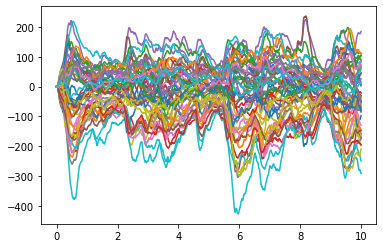

In [46]:
for i in range(test_number_f):
  plt.plot(ytime[1], totalpreds[1][i])

In [47]:
test_likelihoods = - 0.5 * ((n[0] + 1) * jnp.log(2 * jnp.pi * test_sigma_n ** 2) + \
                    jnp.sum((yvel[0] - totalpreds[0])**2, axis = 1)/(test_sigma_n ** 2))

In [48]:
print(np.mean(test_likelihoods))

-49817837536.31461


In [49]:
@partial(jit, static_argnums = (3,))
def Likely(Predictions, Velocity, Sigma_n, N):
  
  Likelihood = - 0.5 * ((N + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                    jnp.sum((Velocity - Predictions)**2, axis = 2)/(Sigma_n ** 2))

  return jnp.mean(Likelihood)

#### ELBO

In [50]:
Diag = pmap(vmap(jnp.diag))

In [51]:
@jit
def SetOff(Matrix, Indices, NewVals):
  return Matrix.at[:, Indices[0], Indices[1]].set(NewVals)

In [52]:
Set = pmap(SetOff, in_axes=(0, None, 0,))

In [53]:
@partial(jit, static_argnums = range(10, 19))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Number_F, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys):
         
  Lag = Lag ** 2.0
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1, 0] - Lag) + Lag

  D = Diag(jnp.exp(L_Diag))

  L_Matrix = Set(D, Indices, L_ODiag)

  KLmap = PmapKL(L_Matrix, V_Vector, Batch_Size, M)

  Predictions = Pred(Sigma_f, Ell, Z_Vector, V_Vector, L_Matrix, TRise,
                TauDiff, Lag, Number_F, Num_Base, M, Batch_Size, K, N0, N1, N2, 
                Spike_Fft, F_Time, Subkeys)

  Likelihood0 = Likely(Predictions[0], Velocity[0], Sigma_n, N0)
  Likelihood1 = Likely(Predictions[1], Velocity[1], Sigma_n, N1)
  Likelihood2 = Likely(Predictions[2], Velocity[2], Sigma_n, N2) 

  KL = jnp.sum(KLmap)
  Exp = jnp.sum([Likelihood0, Likelihood1, Likelihood2])
                  
  return (KL-Exp)/(Num_Filt * (N0 + N1 + N2) + 1)

In [54]:
test_number_f = 15
test_num_base = 100
test_m = int(20)

test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 1 + 4 * num_mach)
test_subkeys = np.asarray(test_subkeys).astype(np.uint32).reshape(num_mach, 4, 2)

test_sigma_f = 2.0 * np.ones((num_mach, batch_size, 1, 1))# np.arange(num_mach * batch_size).reshape(num_mach, batch_size, 1, 1)
test_ell_f = 0.7 * np.ones((num_mach, batch_size, 1, 1))
test_sigma_n = 0.01
test_z_final = jnp.tile(jnp.linspace(0.0, 1.0, test_m).reshape((test_m, 1)), (num_mach, batch_size, 1, 1))
test_z_m = (jnp.arcsin(2.0 * (test_z_final - 0.5)) / jnp.pi) + 0.5
test_v_m = 5.0 * np.ones((num_mach, batch_size, test_m, 1))
test_l_diag = np.ones((num_mach, batch_size, test_m))
test_l_odiag = np.tile(np.tril(np.ones((test_m, test_m)), -1)[np.tril_indices(test_m, -1)], (num_mach, batch_size, 1))
test_trise = 0.02 * np.ones((num_mach, batch_size, 1, 1))
test_tdiff = 0.03 * np.ones((num_mach, batch_size, 1, 1))
test_lag = 0.01 * np.ones((num_mach, batch_size, 1, 1))
test_indices = np.tril_indices(test_m, -1)

In [55]:
nelbo = Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m,
                    test_l_diag, test_l_odiag, test_trise, test_tdiff, test_lag,
                    test_number_f, test_num_base, test_m, num_filt, batch_size,
                    k, *n, test_indices, spikefft, yvel, ftime, test_subkeys)

/root/Bayesian-Convolutional-Model/VastCode/env/lib/python3.8/site-packages/jax/_src/dispatch.py:315: UserWarning: The jitted function Neg_ELBO includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


In [56]:
print(nelbo)

384.9948305334736


In [57]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 19))

In [58]:
testgrad = Grad_Bound(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m,
                    test_l_diag, test_l_odiag, test_trise, test_tdiff, test_lag,
                    test_number_f, test_num_base, test_m, num_filt, batch_size,
                    k, *n, test_indices, spikefft, yvel, ftime, test_subkeys)

In [59]:
print(testgrad[1][4].shape)

(10, 13, 20, 1)


### Optimiser

#### Sub-function Definitions

In [60]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [61]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [62]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [63]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [64]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [65]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [66]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [67]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(CFinState, X, Mhat, Vhat)

  return X, M, V

In [68]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(MFinState, X, Mhat, Vhat)

  return X, M, V

In [69]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(FFinState, X, Mhat, Vhat)

  return X, M, V

In [70]:
@partial(jit, static_argnums = range(8, 18))
def _CUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, 
              Num_Coarse_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N0, N1, N2, Indices, 
              Spike_Fft, Velocity, F_Time):
              
  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [71]:
@partial(jit, static_argnums = range(8, 18))
def _MUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, 
              Num_Mid_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N0, N1, N2, Indices, 
              Spike_Fft, Velocity, F_Time):

  Value, Grads = Grad_Bound(*X, Num_Mid_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [72]:
@partial(jit, static_argnums = range(8, 18))
def _FUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, 
              Num_Fine_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N0, N1, N2, Indices, 
              Spike_Fft, Velocity, F_Time):

  Value, Grads = Grad_Bound(*X, Num_Fine_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N0, N1, N2,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

#### Adam Function Definition

In [73]:
@partial(jit, static_argnums = range(1, 11))
def AdamOpt(Init_Params, Num_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N0, N1, N2, Indices, 
              Spike_Fft, Velocity, F_Time, Coarse_Schedule = jnp.asarray([1500]), 
              Mid_Schedule = jnp.asarray([16500]), Fine_Iters = 2000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = jnp.zeros(15)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(0)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  Params = Init_Params

  def CUpdate(Iter, State):
    return _CUpdate(Iter, *State, Num_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N0, N1, N2, Indices, 
                      Spike_Fft, Velocity, F_Time)

  def MUpdate(Iter, State):
    return _MUpdate(Iter, *State, Num_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N0, N1, N2, Indices, 
                      Spike_Fft, Velocity, F_Time)

  def FUpdate(Iter, State):
    return _FUpdate(Iter, *State, Num_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N0, N1, N2, Indices, 
                      Spike_Fft, Velocity, F_Time)

  JCUpdate = jit(CUpdate)
  JMUpdate = jit(MUpdate)
  JFUpdate = jit(FUpdate)

  def CReset(Iter, State):
    InOptState = lax.fori_loop(0, Coarse_Schedule[Iter], JCUpdate, State)
    return InOptState

  def MReset(Iter, State):
    InOptState = lax.fori_loop(0, Mid_Schedule[Iter], JMUpdate, State)
    return InOptState

  JCReset = jit(CReset)
  JMReset = jit(MReset)

  OptState = lax.fori_loop(0, len(Coarse_Schedule), JCReset, 
                              (Params, Subkeys, Key, ELBO_History, Step, Mad, Vad))

  OptState = lax.fori_loop(0, len(Mid_Schedule), JMReset, OptState)

  OptState = lax.fori_loop(0, Fine_Iters, JFUpdate, OptState)

  return OptState[0], OptState[-4]

In [74]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 1.0 * jnp.ones((num_mach, batch_size, 1, 1))
iell = 0.002 * jnp.ones ((num_mach, batch_size, 1, 1))
isigma_n = 0.000000005
itrise = np.sqrt(0.05) * jnp.ones((num_mach, batch_size, 1, 1))
itaudiff = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))
ilag = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))

# Variational parameters
num_f = 15
num_b = 100
num_ind = 20
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1)), (num_mach, batch_size, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
key, *subkeys = random.split(key, 4)
iv_vector = 0.01 * random.normal(subkeys[-3], (num_mach, batch_size, num_ind, 1))
il_diag = 0.01 * random.normal(subkeys[-2], (num_mach, batch_size, num_ind))
il_odiag = 0.1 * random.normal(subkeys[-1], (num_mach, batch_size, int((num_ind ** 2 - num_ind) / 2)))
indices = jnp.tril_indices(num_ind, -1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, *opt_subkey = random.split(opt_key, 1 + 4 * num_mach)
opt_subkey = np.asarray([opt_subkey[i:i+4] for i in range(num_mach)]).astype(np.uint32)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, num_filt, batch_size, k, *n, indices, spikefft, yvel, ftime)

In [75]:
fparams, elbo_history = AdamOpt(params, num_f, num_b, num_ind, num_filt, num_mach, batch_size,
                                  k, *n, indices, spikefft, yvel, ftime)

/root/Bayesian-Convolutional-Model/VastCode/env/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
/root/Bayesian-Convolutional-Model/VastCode/env/lib/python3.8/site-packages/jax/_src/dispatch.py:315: UserWarning: The jitted function AdamOpt includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


In [ ]:
# %%timeit
# fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [ ]:
print(Neg_ELBO(*params, num_f, num_b, *consparams, opt_subkey))

1982647769549860.0


In [ ]:
print(Neg_ELBO(*fparams, num_f, num_b, *consparams, opt_subkey))

/usr/local/lib/python3.8/dist-packages/jax/_src/dispatch.py:315: UserWarning: The jitted function Neg_ELBO includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


10.934527785214028


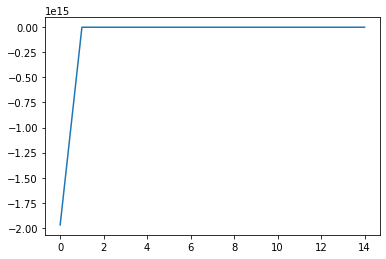

In [ ]:
plt.plot(elbo_history[:])

In [ ]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [ ]:
ilag = ilag ** 2

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag) + ilag

idz = Diag(np.exp(il_diag))
il_matrix = Set(idz, indices, il_odiag)


flag = flag ** 2

fz_vector = (0.5 * np.sin( np.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag) + flag

fd = Diag(np.exp(fl_diag))
fl_matrix = Set(fd, indices, fl_odiag)

In [ ]:
isigma_ff = isigma_f.reshape(num_filt, 1)
iellf = iell.reshape(num_filt, 1)
iz_vectorf = iz_vector.reshape(num_filt, num_ind, 1)
iv_vectorf = iv_vector.reshape(num_filt, num_ind, 1)
il_matrixf = il_matrix.reshape(num_filt, num_ind, num_ind)
itrisef = itrise.reshape(num_filt, 1)
itaudifff = itaudiff.reshape(num_filt, 1)
ilagf = ilag.reshape(num_filt, 1)

fsigma_ff = fsigma_f.reshape(num_filt, 1)
fellf = fell.reshape(num_filt, 1)
fz_vectorf = fz_vector.reshape(num_filt, num_ind, 1)
fv_vectorf = fv_vector.reshape(num_filt, num_ind, 1)
fl_matrixf = fl_matrix.reshape(num_filt, num_ind, num_ind)
ftrisef = ftrise.reshape(num_filt, 1)
ftaudifff = ftaudiff.reshape(num_filt, 1)
flagf = flag.reshape(num_filt, 1)

In [ ]:
print(len(spikefft))

5


In [ ]:
spikeffta = [np.asarray([spikefft[i][j] for i in range(num_mach)]) for j in range(len(trainind))]

In [ ]:
spikefftf = [spikeffta[i].reshape(num_filt, fftlen[i], 1) for i in range(len(trainind))]

In [ ]:
print(len(spikefftf))
print(spikefftf[0].shape)

3
(130, 5501, 1)


In [ ]:
print(fsigma_ff)

[[0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [1.        ]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93878491]
 [0.93

In [ ]:
print(fellf)

[[ 0.06321509]
 [ 0.06321509]
 [-0.05921509]
 [ 0.06321509]
 [ 0.06321509]
 [-0.05921509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [ 0.002     ]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [-0.05921509]
 [ 0.06321509]
 [ 0.06321509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [-0.05921509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [ 0.06321509]
 [ 0.06321509]
 [-0.05921509]
 [ 0.06321509]
 [ 0.06321509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [-0.05921509]
 [-0.05921509]
 [ 0.06321509]
 [ 0.06321

In [ ]:
print(fsigma_n)

0.06121509387713468


In [ ]:
print(ftrisef)

[[0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.2236068 ]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16239171]
 [0.16

In [ ]:
print(ftaudifff)

[[0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.1       ]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03878491]
 [0.03

In [ ]:
print(flagf)

[[0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.00150427]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.00150427]
 [0.01      ]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.00150427]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.00150427]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.0259903 ]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.0259903 ]
 [0.00150427]
 [0.0259903 ]
 [0.00150427]
 [0.02599031]
 [0.00150427]
 [0.0259903 ]
 [0.02

## Variational Predictions

In [ ]:
fpred_points = ftime.copy()

In [ ]:
scisigmaf = isigma_ff[:, None]
sciellf = iellf[:, None]
scitrisef = itrisef[:, None]
scitaudifff = itaudifff[:, None]
scilagf = ilagf[:, None]

ikmm = Squared_exp(iz_vectorf, iz_vectorf.transpose(0, 2, 1), scisigmaf, sciellf)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vectorf, fpred_points.T, scisigmaf, sciellf)
ibzast = np.zeros((num_filt, num_ind, k + 1))
for i in range(num_filt):
  ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, scitrisef, scitaudifff, scilagf)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vectorf)
ikastast = Squared_exp(fpred_points, fpred_points.T, scisigmaf, sciellf)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrixf @ il_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [ ]:
scfsigmaf = fsigma_ff[:, None]
scfellf = fellf[:, None]
scftrisef = ftrisef[:, None]
scftaudifff = ftaudifff[:, None]
scflagf = flagf[:, None]

fkmm = Squared_exp(fz_vectorf, fz_vectorf.transpose(0, 2, 1), scfsigmaf, scfellf)
fcpred = np.linalg.cholesky(fkmm + 1e-6 * np.eye(num_ind))
fkzast = Squared_exp(fz_vectorf, fpred_points.T, scfsigmaf, scfellf)
fbzast = np.zeros((num_filt, num_ind, k + 1))
for i in range(num_filt):
  fbzast[i] = sc.linalg.solve_triangular(fcpred[i], fkzast[i], lower = True)
fbzastT = fbzast.transpose(0, 2, 1)
fpredenv = AlpEnvelope(fpred_points, scftrisef, scftaudifff, scflagf)
fpredenvT = fpredenv.transpose(0, 2, 1)
fmeanpred = fpredenv * (fbzastT @ fv_vectorf)

fkastast = Squared_exp(fpred_points, fpred_points.T, scfsigmaf, scfellf)
fcovpred = fpredenv * (fkastast + fbzastT @ (fl_matrixf @ fl_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ fbzast) * fpredenvT

In [ ]:
print(imeanpred.shape)

(130, 1001, 1)


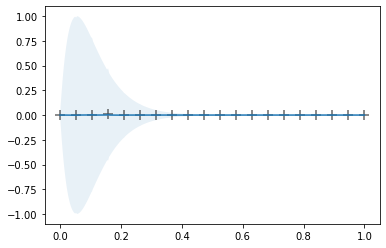

In [ ]:
ipredindenv = AlpEnvelope(iz_vectorf, scitrisef, scitaudifff, scilagf)
index = 2
plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vectorf[index], (ipredindenv * (icpred @ iv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

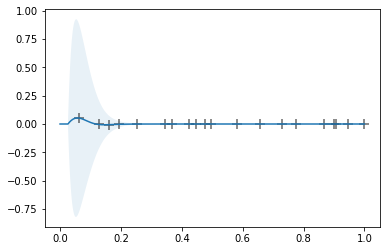

In [ ]:
predindenv = AlpEnvelope(fz_vectorf, scftrisef, scftaudifff, scflagf)

plt.plot(fpred_points, fmeanpred[index])
s2 = np.sqrt(np.diag(fcovpred[index]))
fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

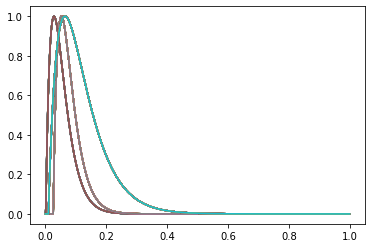

In [ ]:
envelopes = AlpEnvelope(ftime, scftrisef, scftaudifff, scflagf)
for i in envelopes:
  plt.plot(ftime, i)

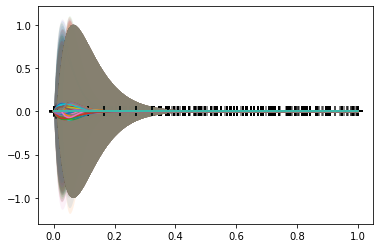

In [ ]:
for index in range(num_filt):
  plt.plot(fpred_points, fmeanpred[index])
  s2 = np.sqrt(np.diag(fcovpred[index]))
  fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
  plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
  plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
  #plt.xlim([ftime[0], ftime[-1]])

In [ ]:
def OUTconvolve(Filters, K, N, Spike_FFT):
  Pad = np.hstack((Filters, np.zeros((num_filt, N, 1))))
  Pred_fft = np.fft.rfft(Pad, axis = -2)
  Pred_sum = np.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = np.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

In [ ]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

imeanpredict = OUTconvolve(imeanpred, k, n, spikefftf)
imeanpredictns2 = OUTconvolve(imeanpred - 2 * is2, k, n, spikefftf)
imeanpredictps2 = OUTconvolve(imeanpred + 2 * is2, k, n, spikefftf)

In [ ]:
fs2 = np.sqrt(np.diagonal(fcovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

fmeanpredict = OUTconvolve(fmeanpred, k, n, spikefftf)
fmeanpredictns2 = OUTconvolve(fmeanpred - 2 * fs2, k, n, spikefftf)
fmeanpredictps2 = OUTconvolve(fmeanpred + 2 * fs2, k, n, spikefftf)

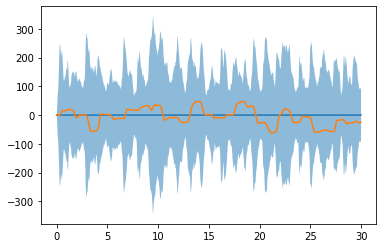

In [ ]:
plt.plot(ytime, imeanpredict)
plt.plot(ytime, yvel)
plt.fill_between(ytime.flatten(), imeanpredictns2.flatten() - 2 * isigma_n,  
                  imeanpredictps2.flatten() + 2 * isigma_n, alpha = 0.5)

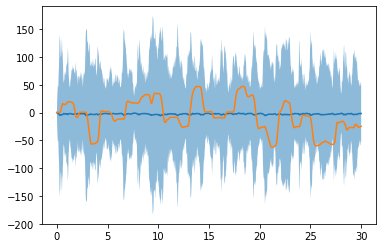

In [ ]:
plt.plot(ytime, fmeanpredict)
plt.plot(ytime, yvel)
plt.fill_between(ytime.flatten(), fmeanpredictns2.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2.flatten() + 2 * fsigma_n, alpha = 0.5)

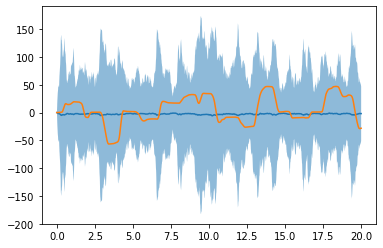

In [ ]:
ytesttru = yvel[:20000]
ytimetru = ytime[:20000]
fmeanpredicttru = fmeanpredict[:20000]
fmeanpredictns2tru = fmeanpredictns2[:20000]
fmeanpredictps2tru = fmeanpredictps2[:20000]
plt.plot(ytimetru, fmeanpredicttru)
plt.plot(ytimetru, ytesttru)
plt.fill_between(ytimetru.flatten(), fmeanpredictns2tru.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2tru.flatten() + 2 * fsigma_n, alpha = 0.5)

## Testing Against New Data

In [ ]:
kext = 3000
xnew = data.spikes.to_numpy()[:k + 1 + kext, :num_filt]
ytimenew = (data.index / np.timedelta64(1, 's')).to_numpy()[:k + 1 + kext]
ycoordnew = data.finger_pos.y.to_numpy()[:k + 1 + kext]
xcoordnew = data.finger_pos.x.to_numpy()[:k + 1 + kext]
ytestnew = ycoordnew.reshape(k + 1 + kext, 1)
xnewtes = xnew.T[:, :, None]

ytestnew -= ytestnew[0, 0]
xnew = xnew.T[:,:,None]
print(np.where(xtest != xnewtes[:, :k + 1]))
print(xnew.shape)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(10, 5500, 1)


In [ ]:
ktotal = kext + k

In [ ]:
xnewpad = np.hstack((xnew, np.zeros((num_filt, ktotal, 1))))
xnewfft = np.fft.rfft(xnewpad, n + ktotal + 1, axis = 1)[:, :ktotal + 1]
fnew = OUTconvolve(fmeanpred, n, ktotal, xnewfft)

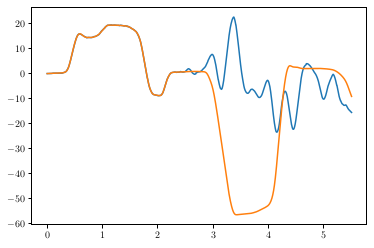

In [ ]:
plt.plot(ytimenew, fnew)
plt.plot(ytimenew, ytestnew)

## $R^2$ Value

### On training data

## Fixing Convolution

In [ ]:
%%capture
fmeanpred # the filter for each spike train
xtest # the original spike data

### One spike train

#### Numpy convolution

In [ ]:
indy = 20 # index of train checking
outindy = np.convolve(xtest[indy].flatten(), fmeanpred[indy].flatten())[:k + 1]

IndexError: index 20 is out of bounds for axis 0 with size 10

In [ ]:
convolutions = np.zeros((num_filt, k + 1))
for i in range(num_filt):
  convolutions[i] = np.convolve(xtest[i].flatten(), fmeanpred[i].flatten())[:k + 1]
prediction = np.sum(convolutions, axis=0)
print(np.shape(prediction))

(80000,)


In [ ]:
print(np.equal(fullindy, prediction))

[ True  True  True ...  True  True  True]


#### FFT convolution

In [ ]:
xindypad = np.vstack((xtest[indy], np.zeros((n, 1))))
xindyfft = np.fft.rfft(xindypad, axis = 0)

findypad = np.vstack((fmeanpred[indy], np.zeros((k, 1))))
findyfft = np.fft.rfft(findypad, axis = 0)
outfftindy = np.fft.irfft(xindyfft * findyfft, n + k + 1, axis = 0)[:k + 1]

(3.0, 5.0)

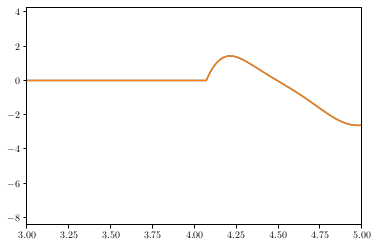

In [ ]:
plt.plot(ytime, outindy)
plt.plot(ytime, outfftindy)
plt.xlim([3.0, 5.0])

In [ ]:
fullindy = np.zeros(k + 1)
fftindy = np.zeros(k + 1)
for i in range(num_filt):
  fullindy += np.convolve(xtest[i].flatten(), fmeanpred[i].flatten())[:k + 1] # np convolution

  xindypad = np.vstack((xtest[i], np.zeros((n, 1))))
  xindyfft = np.fft.rfft(xindypad, axis = 0)

  findypad = np.vstack((fmeanpred[i], np.zeros((k, 1))))
  findyfft = np.fft.rfft(findypad, axis = 0)
  fftindy += np.fft.irfft(xindyfft * findyfft, n + k + 1, axis = 0).flatten()[:k + 1]

(0.0, 10.0)

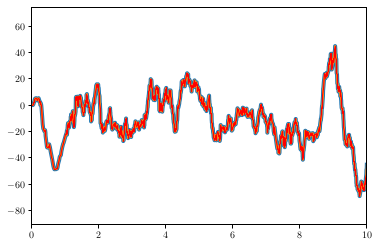

In [ ]:
plt.plot(ytime, fullindy, linewidth = 4.0)
plt.plot(ytime, fftindy, linewidth = 2.0)
plt.plot(ytime, prediction, linewidth = 0.5, color = 'red')
plt.xlim([0.0, 10.0])